In [16]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import shap
#標準化とパイプライン　その他の便利ツール
from sklearn.preprocessing import StandardScaler,Imputer,LabelEncoder

from scipy import stats #アルゴリズムランキング
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE


#アルゴリズム
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.linear_model import LogisticRegression #ロジスティクス回帰
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,VotingClassifier,BaggingClassifier #勾配ブースティング ランダムフォレスト
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
import catboost as cb
from catboost import CatBoostClassifier
import lightgbm as lgb

#評価方法
from sklearn.model_selection import train_test_split,cross_val_score,KFold,ShuffleSplit,StratifiedKFold#交差検証,K-fold、シャッフル分割交差検証
#評価指標
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
#ファイル保存
from sklearn.externals import joblib
#コンペ用ツール
import category_encoders as ce
from hyperopt import fmin,hp,tpe,Trials,STATUS_OK,space_eval
from functools import partial
import pandas_profiling as pdp
import time
#EDA
%matplotlib inline
import matplotlib.pyplot as plt

seed=2018
kfold=KFold(n_splits=20,shuffle=True,random_state=seed)
shuffle_split=ShuffleSplit(test_size=.7,train_size=.3,n_splits=5,random_state=seed)
strkfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=seed)

"""
評価手法
'accuracy'
'average_precision'
'f1'
'f1_micro'
'f1_macro'
'f1_weighted'
'f1_samples'
'neg_log_loss'
'precision'
'recall'
'roc_auc'
"""
#scoring_method='accuracy'
scoring_method='roc_auc'
df = pd.read_csv('./data/mushrooms.csv', header=0)

#LabelEncoder
for col in df.columns:
    le=LabelEncoder()
    le.fit(df[col])
    df[col]=le.transform(df[col])

df.head()

class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0      1          5            2          4        1     6                1   
1      0          5            2          9        1     0                1   
2      0          0            2          8        1     3                1   
3      1          5            3          8        1     6                1   
4      0          5            2          3        0     5                1   

   gill-spacing  gill-size  gill-color   ...     stalk-surface-below-ring  \
0             0          1           4   ...                            2   
1             0          0           4   ...                            2   
2             0          0           5   ...                            2   
3             0          1           5   ...                            2   
4             1          0           4   ...                            2   

   stalk-color-above-ring  stalk-color-below-ring  veil-type  veil-color  \
0                       7                       7          0           2   
1                       7                       7          0           2   
2                       7                       7          0           2   
3                       7                       7          0           2   
4                       7                       7          0           2   

   ring-number  ring-type  spore-print-color  population  habitat  
0            1          4                  2           3        5  
1            1          4                  3           2        1  
2            1          4                  3           2        3  
3            1          4                  2           3        5  
4            1          0                  3           0        1  

[5 rows x 23 columns]

In [18]:
#欠損確認
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [19]:
df,df_s=train_test_split(df,test_size=0.2,random_state=1)
df=df.reset_index(drop=True)
df_s=df_s.reset_index(drop=True)
df.head()

class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0      0          5            0          4        0     5                1   
1      0          5            2          3        0     5                1   
2      1          5            3          2        0     8                1   
3      1          5            2          2        0     8                1   
4      0          5            0          4        1     5                1   

   gill-spacing  gill-size  gill-color   ...     stalk-surface-below-ring  \
0             1          0           4   ...                            2   
1             1          0           4   ...                            2   
2             0          1           0   ...                            1   
3             0          1           0   ...                            2   
4             0          0          10   ...                            2   

   stalk-color-above-ring  stalk-color-below-ring  veil-type  veil-color  \
0                       7                       7          0           2   
1                       7                       7          0           2   
2                       6                       6          0           2   
3                       6                       6          0           2   
4                       3                       3          0           2   

   ring-number  ring-type  spore-print-color  population  habitat  
0            1          0                  2           0        1  
1            1          0                  2           3        1  
2            1          0                  7           4        0  
3            1          0                  7           4        2  
4            1          4                  3           4        0  

[5 rows x 23 columns]

In [20]:
#別途確認しveil-typeはすべての値がpなのでDropする。
X=df.drop(["class","veil-type"],axis=1)
y=df["class"]

X_s=df_s.drop(["class","veil-type"],axis=1)
y_s=df_s["class"]


In [21]:

start=time.time()
def score(params):
    print("Training with params :")
    print(params)
    num_round=int(params['n_estimators'])
   
    lgb_model = lgb.LGBMClassifier(**params,num_boost_round=num_round)
    score = cross_val_score(lgb_model,X, y, cv=strkfold, scoring=scoring_method).mean()
    print ("\tScore {0}\n\n".format(score))
    return 1-score

space={'n_estimators' : hp.quniform('n_estimators', 10, 100, 10),
    'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
     'min_data_in_leaf':  hp.choice('min_data_in_leaf', np.arange(1000, 2000, dtype=int)),
    'boosting_type' : hp.choice('boosting_type',['gbdt','dart','goss']),
    'objective' :hp.choice('objective', ['binary']),
    'tree_learner':hp.choice('tree_learner',['feature']),
    'metric':hp.choice('metric',['auc']),
    'seed':hp.choice('seed',[seed])
    }
def optimize(trials,space):
    best = fmin(score,space=space,algo=tpe.suggest,
            max_evals=20,
            trials=trials,rstate= np.random.RandomState(seed))
    return best
trials=Trials()
best=optimize(trials,space)
#変換
best=space_eval(space,best)
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")


Training with params :
{'boosting_type': 'goss', 'max_depth': 3, 'metric': 'auc', 'min_data_in_leaf': 1034, 'n_estimators': 30.0, 'objective': 'binary', 'seed': 2018, 'tree_learner': 'feature'}
	Score 0.9868562068318859


Training with params :
{'boosting_type': 'goss', 'max_depth': 5, 'metric': 'auc', 'min_data_in_leaf': 1607, 'n_estimators': 70.0, 'objective': 'binary', 'seed': 2018, 'tree_learner': 'feature'}
	Score 0.9680468284151258


Training with params :
{'boosting_type': 'gbdt', 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 1321, 'n_estimators': 40.0, 'objective': 'binary', 'seed': 2018, 'tree_learner': 'feature'}
	Score 0.9876095605850299


Training with params :
{'boosting_type': 'goss', 'max_depth': 9, 'metric': 'auc', 'min_data_in_leaf': 1089, 'n_estimators': 50.0, 'objective': 'binary', 'seed': 2018, 'tree_learner': 'feature'}
	Score 0.9851896436215531


Training with params :
{'boosting_type': 'dart', 'max_depth': 11, 'metric': 'auc', 'min_data_in_leaf': 1055, 'n_

In [102]:
print("Hyperopt estimated optimum {}".format(best))
nrounds=int(best['n_estimators'])

Hyperopt estimated optimum {'boosting_type': 'dart', 'max_depth': 11, 'metric': 'auc', 'min_data_in_leaf': 1055, 'n_estimators': 80.0, 'objective': 'binary', 'seed': 2018, 'tree_learner': 'feature'}


In [103]:
best['n_estimators']

80.0

In [22]:
best = {'boosting_type': 'dart', 'max_depth': 11, 'metric': 'auc', 'min_data_in_leaf': 1055, 'n_estimators': 80.0, 'objective': 'binary', 'seed': 2018, 'tree_learner': 'feature'}


In [23]:
nrounds=int(best['n_estimators'])
categorical=X.columns.values

In [24]:
for j, (train_index, test_index) in enumerate(strkfold.split(X, y)):
    X_train, X_eval = X.iloc[train_index], X.iloc[test_index]
    y_train, y_eval = y[train_index], y[test_index]
    lgb_train = lgb.Dataset(X_train, label=y_train.ravel(),feature_name=list(X.columns.values))
    lgb_eval =lgb.Dataset(X_eval, label=y_eval.ravel())
    lgb_model = lgb.train(best, lgb_train, nrounds, 
                    lgb_eval, verbose_eval=1, 
                    #feval=gini_lgb,
                              #categorical_feature=ohe_columns,
                              early_stopping_rounds=20)

[1]	valid_0's auc: 0.898457
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.898457
[3]	valid_0's auc: 0.95925
[4]	valid_0's auc: 0.959666
[5]	valid_0's auc: 0.969112
[6]	valid_0's auc: 0.974728
[7]	valid_0's auc: 0.98241
[8]	valid_0's auc: 0.988224
[9]	valid_0's auc: 0.987855
[10]	valid_0's auc: 0.987969
[11]	valid_0's auc: 0.987969
[12]	valid_0's auc: 0.98725
[13]	valid_0's auc: 0.987137
[14]	valid_0's auc: 0.989378
[15]	valid_0's auc: 0.98952
[16]	valid_0's auc: 0.98951
[17]	valid_0's auc: 0.989614
[18]	valid_0's auc: 0.990465
[19]	valid_0's auc: 0.990673
[20]	valid_0's auc: 0.990578
[21]	valid_0's auc: 0.990692
[22]	valid_0's auc: 0.990692
[23]	valid_0's auc: 0.991136
[24]	valid_0's auc: 0.991136
[25]	valid_0's auc: 0.991117
[26]	valid_0's auc: 0.991004
[27]	valid_0's auc: 0.990994
[28]	valid_0's auc: 0.992016
[29]	valid_0's auc: 0.992016
[30]	valid_0's auc: 0.991751
[31]	valid_0's auc: 0.992554
[32]	valid_0's auc: 0.992621
[33]	valid_0's auc: 0.99

[51]	valid_0's auc: 0.991378
[52]	valid_0's auc: 0.991075
[53]	valid_0's auc: 0.991075
[54]	valid_0's auc: 0.991075
[55]	valid_0's auc: 0.991075
[56]	valid_0's auc: 0.991625
[57]	valid_0's auc: 0.991075
[58]	valid_0's auc: 0.991625
[59]	valid_0's auc: 0.991625
[60]	valid_0's auc: 0.991625
[61]	valid_0's auc: 0.991075
[62]	valid_0's auc: 0.991075
[63]	valid_0's auc: 0.991075
[64]	valid_0's auc: 0.991075
[65]	valid_0's auc: 0.991625
[66]	valid_0's auc: 0.991625
[67]	valid_0's auc: 0.991644
[68]	valid_0's auc: 0.991644
[69]	valid_0's auc: 0.99172
[70]	valid_0's auc: 0.991701
[71]	valid_0's auc: 0.99172
[72]	valid_0's auc: 0.991776
[73]	valid_0's auc: 0.991663
[74]	valid_0's auc: 0.991663
[75]	valid_0's auc: 0.991739
[76]	valid_0's auc: 0.991739
[77]	valid_0's auc: 0.991739
[78]	valid_0's auc: 0.991776
[79]	valid_0's auc: 0.991909
[80]	valid_0's auc: 0.991909
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.991909
[1]	valid_0's auc: 0.874802
Training until validation s

[28]	valid_0's auc: 0.993835
[29]	valid_0's auc: 0.993835
[30]	valid_0's auc: 0.993711
[31]	valid_0's auc: 0.994081
[32]	valid_0's auc: 0.994129
[33]	valid_0's auc: 0.994328
[34]	valid_0's auc: 0.994214
[35]	valid_0's auc: 0.9941
[36]	valid_0's auc: 0.994413
[37]	valid_0's auc: 0.994461
[38]	valid_0's auc: 0.995191
[39]	valid_0's auc: 0.995201
[40]	valid_0's auc: 0.995153
[41]	valid_0's auc: 0.995134
[42]	valid_0's auc: 0.995248
[43]	valid_0's auc: 0.995201
[44]	valid_0's auc: 0.995163
[45]	valid_0's auc: 0.995115
[46]	valid_0's auc: 0.995115
[47]	valid_0's auc: 0.995125
[48]	valid_0's auc: 0.995239
[49]	valid_0's auc: 0.995106
[50]	valid_0's auc: 0.995106
[51]	valid_0's auc: 0.99522
[52]	valid_0's auc: 0.995106
[53]	valid_0's auc: 0.995106
[54]	valid_0's auc: 0.995125
[55]	valid_0's auc: 0.995106
[56]	valid_0's auc: 0.995144
[57]	valid_0's auc: 0.995115
[58]	valid_0's auc: 0.995115
[59]	valid_0's auc: 0.995077
[60]	valid_0's auc: 0.995172
[61]	valid_0's auc: 0.995163
[62]	valid_0's au

In [25]:
for j, (train_index, test_index) in enumerate(strkfold.split(X, y)):
    X_train, X_eval = X.iloc[train_index], X.iloc[test_index]
    y_train, y_eval = y[train_index], y[test_index]
    lgb_train = lgb.Dataset(X_train, label=y_train.ravel(),feature_name=list(X.columns.values),
                            categorical_feature=categorical)
    lgb_eval =lgb.Dataset(X_eval, label=y_eval.ravel(),reference=lgb_train)
    lgb_model = lgb.train(best, lgb_train, nrounds, 
                    lgb_eval, verbose_eval=1,
                              categorical_feature=categorical,
                              early_stopping_rounds=300)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

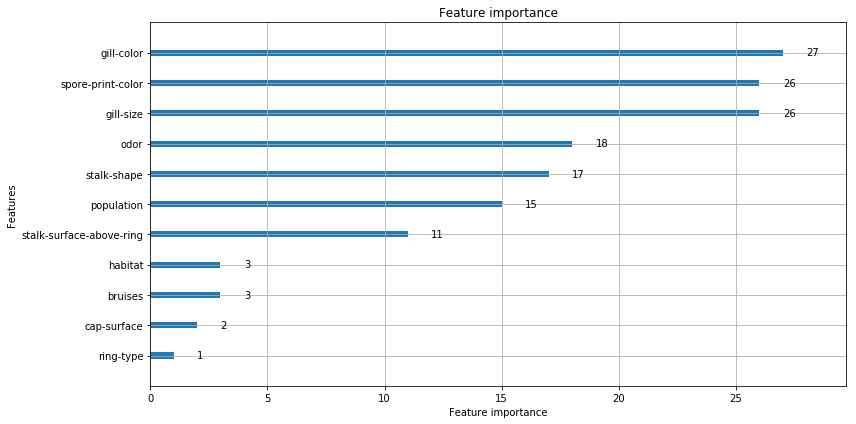

In [26]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_model, figsize=(12, 6))
plt.tight_layout()#見切れ防止
plt.savefig("NativeLightGBM.png")
plt.show()

In [27]:
# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X)
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [28]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

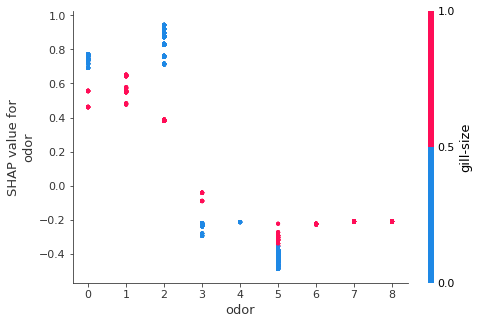

In [29]:
shap.dependence_plot("odor", shap_values, X)

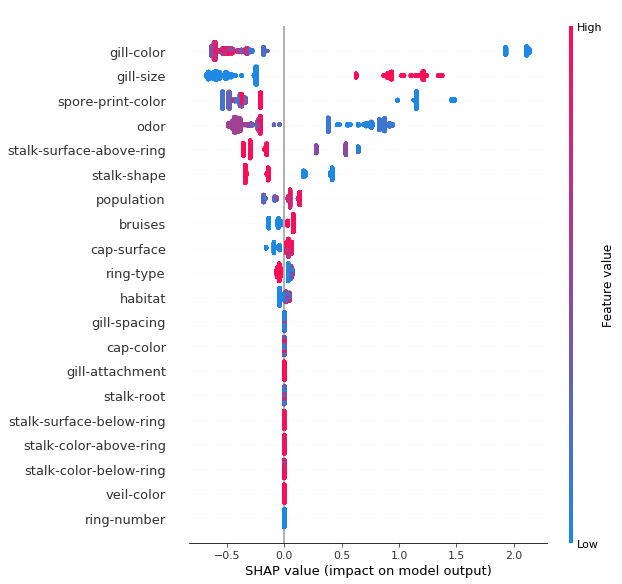

In [30]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

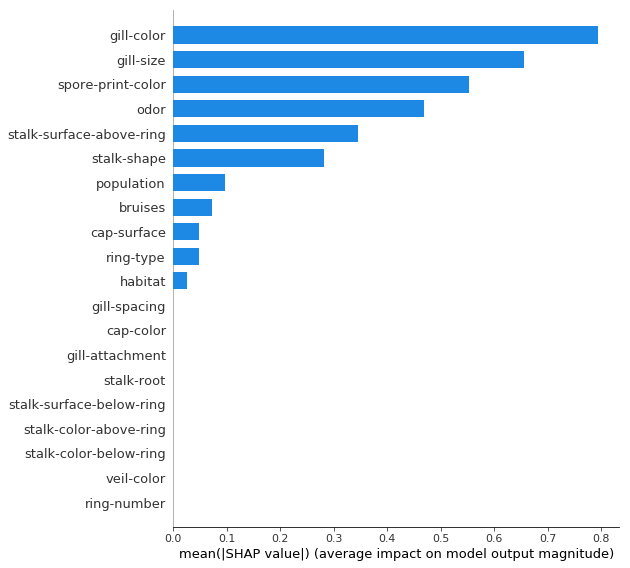

In [31]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
#X_s=pd.DataFrame(X_s, columns=X_s.columns)
    #X_s=X_s.drop(drop_in,axis=1)
    #ID_s =df_s.iloc[:, [0]]
X_s=df_s

#encoder=ce.TargetEncoder(cols=categorical).fit(X,y)
#X_s=encoder.transform(X_s)
ID_s =df_s

In [33]:
y_pred= lgb_model.predict(X_s, num_iteration=lgb_model.best_iteration)
#LightGBMはデフォルトでは予測確率を返すためnumpyで変換。
y_pred=np.where(y_pred < 0.5, 0, 1)

#評価
print(accuracy_score(y_s,y_pred))

0.9735384615384616